In [61]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [62]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INDF.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,7400.0,7500.0,7375.0,7500.0,5944.014160,9181300
1,2017-12-19,7500.0,7700.0,7475.0,7650.0,6062.894531,15706100
2,2017-12-20,7650.0,7700.0,7425.0,7550.0,5983.640625,14606300
3,2017-12-21,7525.0,7600.0,7475.0,7600.0,6023.267578,10857700
4,2017-12-22,7600.0,7625.0,7575.0,7625.0,6043.080566,4686000


In [63]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [64]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0
...,...,...,...,...,...
1489,2023-12-08,6400.0,6400.0,6425.0,6325.0
1490,2023-12-11,6375.0,6400.0,6400.0,6325.0
1491,2023-12-12,6425.0,6375.0,6425.0,6350.0
1492,2023-12-13,6400.0,6400.0,6425.0,6350.0


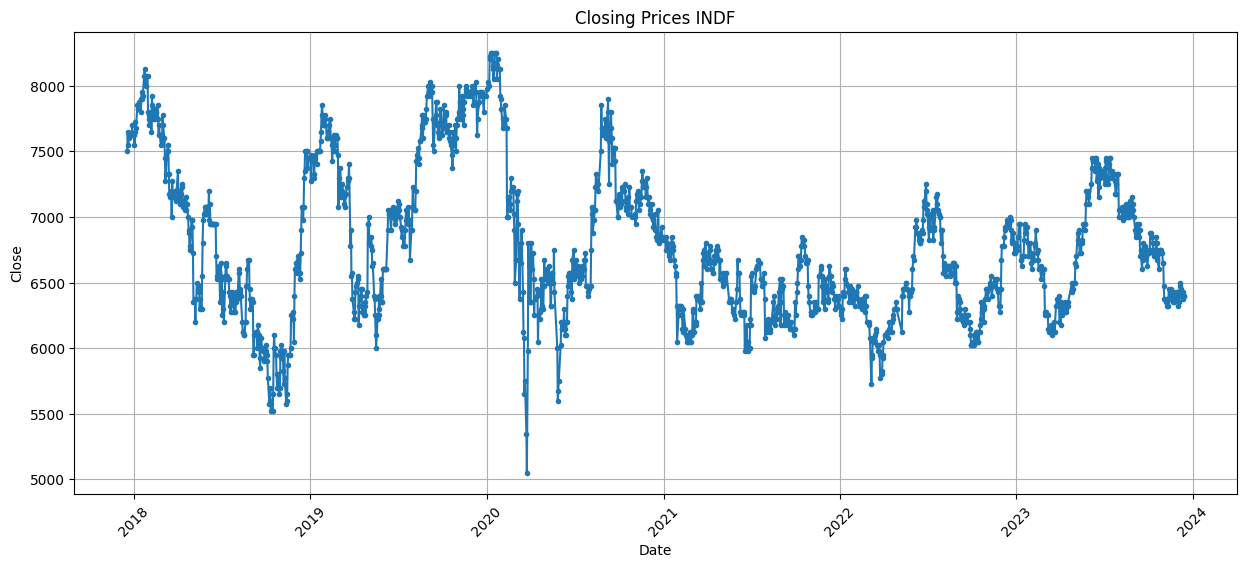

In [65]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

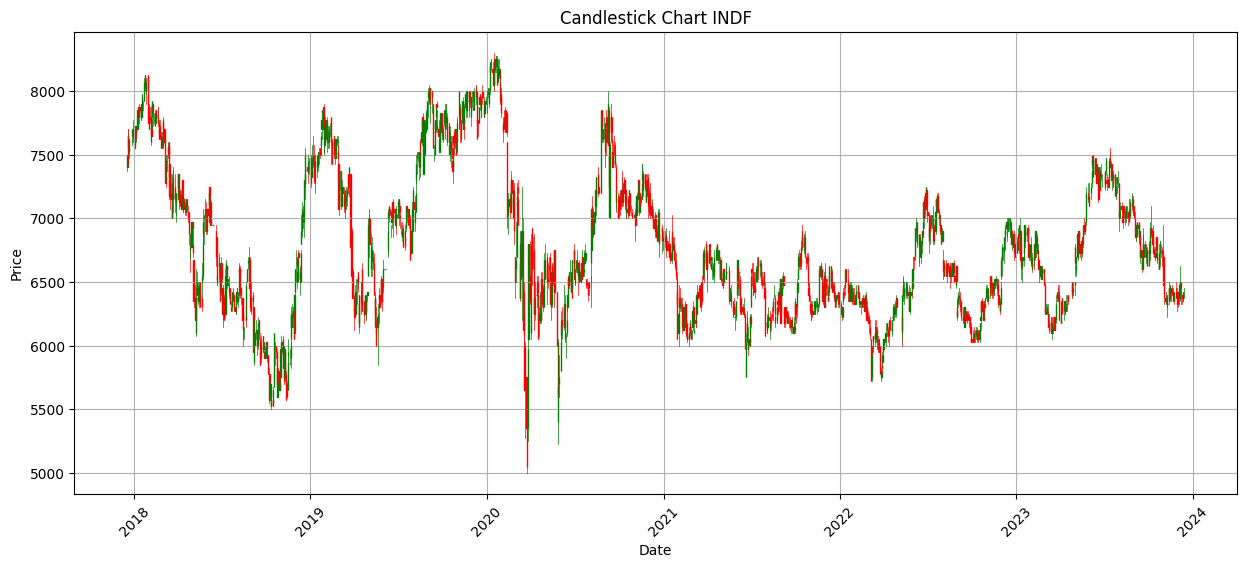

In [66]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart INDF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

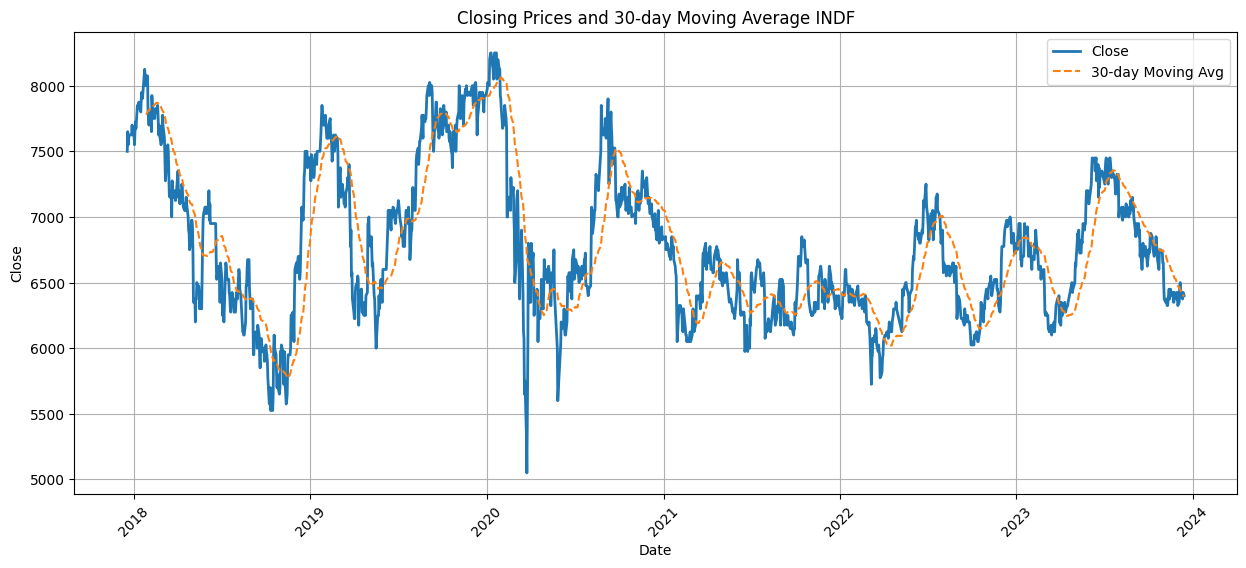

In [67]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [68]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0


In [69]:
new_df = specific_df.reset_index()['Close']

In [70]:
new_df

0       7500.0
1       7650.0
2       7550.0
3       7600.0
4       7625.0
         ...  
1489    6400.0
1490    6375.0
1491    6425.0
1492    6400.0
1493    6400.0
Name: Close, Length: 1494, dtype: float64

In [71]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

Partisi Data

In [72]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [73]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [74]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1135, 60)
(1135,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [75]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

LAyer = 3

dropout = 0.9

In [76]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [77]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [78]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [79]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 9s 72ms/step - loss: 0.1505 - val_loss: 0.0171
Epoch 2/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0866 - val_loss: 0.0266
Epoch 3/100
36/36 [==============================] - 2s 49ms/step - loss: 0.0745 - val_loss: 0.0074
Epoch 4/100
36/36 [==============================] - 2s 49ms/step - loss: 0.0632 - val_loss: 0.0085
Epoch 5/100
36/36 [==============================] - 2s 53ms/step - loss: 0.0537 - val_loss: 0.0167
Epoch 6/100
36/36 [==============================] - 2s 44ms/step - loss: 0.0512 - val_loss: 0.0120
Epoch 7/100
36/36 [==============================] - 2s 42ms/step - loss: 0.0446 - val_loss: 0.0104
Epoch 8/100
36/36 [==============================] - 2s 42ms/step - loss: 0.0411 - val_loss: 0.0086
Epoch 9/100
36/36 [==============================] - 2s 44ms/step - loss: 0.0388 - val_loss: 0.0052
Epoch 10/100
36/36 [==============================] - 2s 50ms/step - loss: 0.0338 - val_loss: 0.0114

In [80]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 10ms/step


In [81]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [82]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.07889460398887779
0.052627095993343934


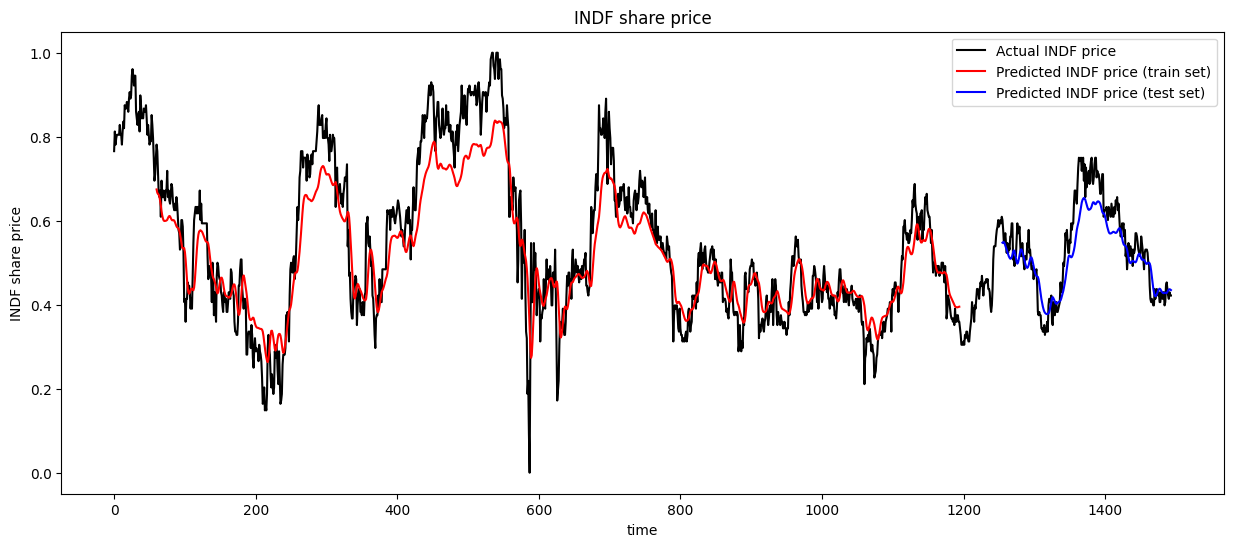

In [83]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [84]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 20ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6441.5224609375
Day 2: Predicted Price = 6438.24755859375
Day 3: Predicted Price = 6437.3955078125
Day 4: Predicted Price = 6438.77783203125
Day 5: Predicted Price = 6441.64111328125
Day 6: Predicted Price = 6445.1826171875
Day 7: Predicted Price = 6448.79541015625
Day 8: Predicted Price = 6452.11865234375
Day 9: Predicted Price = 6455.00634765625
Day 10: Predicted Price = 6457.4462890625
Day 11: Predicted Price = 6459.49951171875
Day 12: Predicted Price = 6461.248046875
Day 13: Predicted Price = 6462.77001953125
Day 14: Predicted Price = 6464.1259765625
Day 15: Predicted Price = 6465.357421875
Day 16: Predicted Price = 6466.4892578125
Day 17: Predicted Price = 6467.5390625
Day 18: Predicted Price = 6468.51513671875
Day 19: Predicted Price = 6469.4228515625
Day 20: Predicted Price = 6470.2666015625
Day 21: Predicted Price = 6471.04931640625
Day 22: Predicted Price = 6471.77587

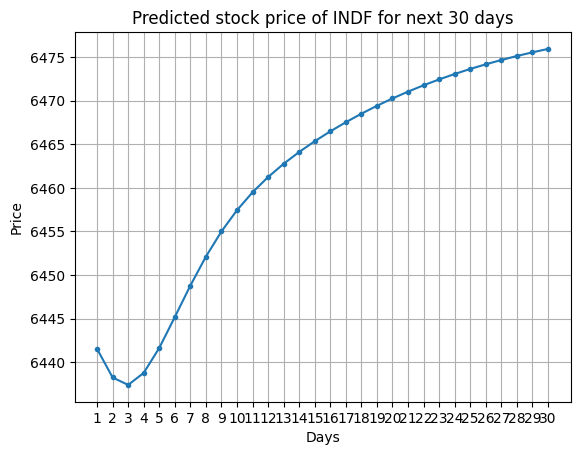

In [85]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [86]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 11ms/step - loss: 0.0028
Validation Loss: 0.0027696113102138042
Validation MSE Loss: 0.0027696113102138042


In [87]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.07889460398887779
Testing RMSE: 0.052627095993343934


dropout = 0.8

In [88]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.8))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.8))

model.add(LSTM(units=50))
model.add(Dropout(0.8))

model.add(Dense(units=1))

In [89]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_15 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [90]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [91]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100


36/36 [==============================] - 7s 75ms/step - loss: 0.0943 - val_loss: 0.0092
Epoch 2/100
36/36 [==============================] - 2s 43ms/step - loss: 0.0459 - val_loss: 0.0078
Epoch 3/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0407 - val_loss: 0.0126
Epoch 4/100
36/36 [==============================] - 2s 45ms/step - loss: 0.0383 - val_loss: 0.0052
Epoch 5/100
36/36 [==============================] - 2s 50ms/step - loss: 0.0323 - val_loss: 0.0044
Epoch 6/100
36/36 [==============================] - 2s 45ms/step - loss: 0.0315 - val_loss: 0.0064
Epoch 7/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0282 - val_loss: 0.0069
Epoch 8/100
36/36 [==============================] - 2s 54ms/step - loss: 0.0266 - val_loss: 0.0035
Epoch 9/100
36/36 [==============================] - 2s 52ms/step - loss: 0.0251 - val_loss: 0.0034
Epoch 10/100
36/36 [==============================] - 2s 53ms/step - loss: 0.0250 - val_loss: 0.0033
Epoch 11/10

In [92]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 14ms/step


In [93]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [94]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.060019544414280326
0.03729522416226234


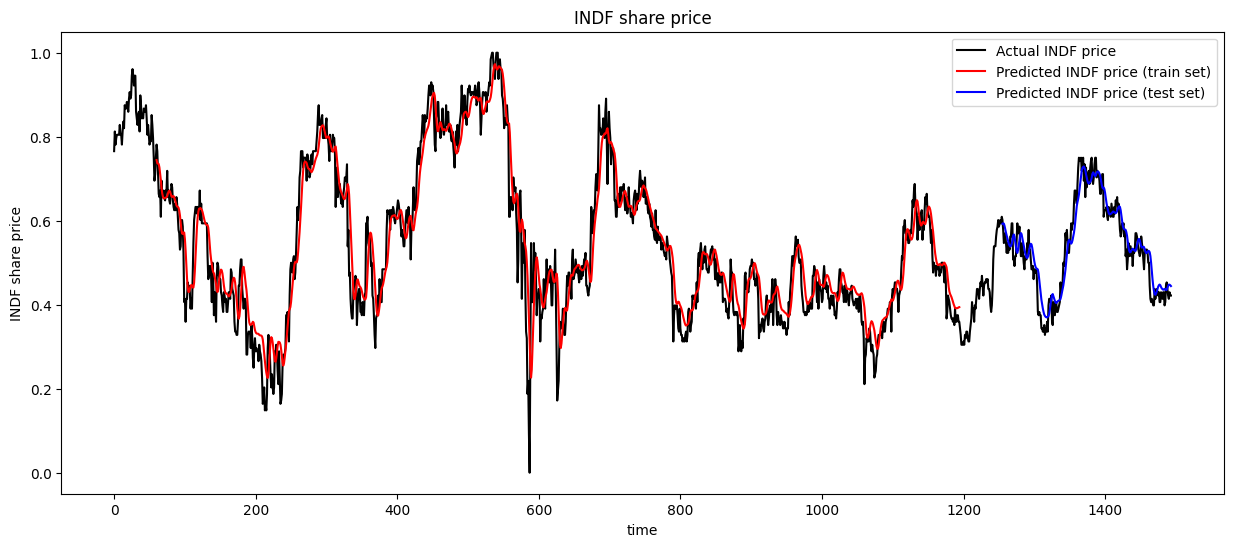

In [95]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [96]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 16ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6472.16259765625
Day 2: Predicted Price = 6471.41650390625
Day 3: Predicted Price = 6476.97900390625
Day 4: Predicted Price = 6486.8486328125
Day 5: Predicted Price = 6498.841796875
Day 6: Predicted Price = 6511.42578125
Day 7: Predicted Price = 6523.76806640625
Day 8: Predicted Price = 6535.52392578125
Day 9: Predicted Price = 6546.61474609375
Day 10: Predicted Price = 6557.076171875
Day 11: Predicted Price = 6566.9736328125
Day 12: Predicted Price = 6576.37548828125
Day 13: Predicted Price = 6585.33837890625
Day 14: Predicted Price = 6593.90869140625
Day 15: Predicted Price = 6602.12646484375
Day 16: Predicted Price = 6610.02490234375
Day 17: Predicted Price = 6617.634765625
Day 18: Predicted Price = 6624.97998046875
Day 19: Predicted Price = 6632.0810546875
Day 20: Predicted Price = 6638.955078125
Day 21: Predicted Price = 6645.61669921875
Day 22: Predicted Price = 6652.076

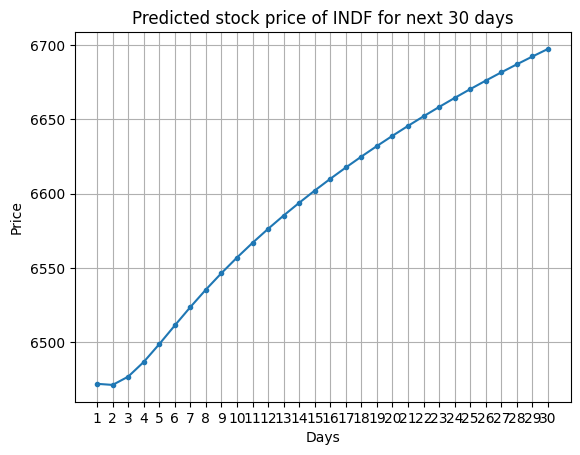

In [97]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [98]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 9ms/step - loss: 0.0014
Validation Loss: 0.0013909336412325501
Validation MSE Loss: 0.0013909336412325501


In [99]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.060019544414280326
Testing RMSE: 0.03729522416226234


dropout = 0.7

In [100]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.7))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.7))

model.add(LSTM(units=50))
model.add(Dropout(0.7))

model.add(Dense(units=1))

In [101]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_18 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_19 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [102]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [103]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 7s 78ms/step - loss: 0.0749 - val_loss: 0.0126
Epoch 2/100
36/36 [==============================] - 2s 54ms/step - loss: 0.0386 - val_loss: 0.0042
Epoch 3/100
36/36 [==============================] - 2s 53ms/step - loss: 0.0314 - val_loss: 0.0058
Epoch 4/100
36/36 [==============================] - 2s 52ms/step - loss: 0.0290 - val_loss: 0.0036
Epoch 5/100
36/36 [==============================] - 2s 50ms/step - loss: 0.0229 - val_loss: 0.0035
Epoch 6/100
36/36 [==============================] - 2s 44ms/step - loss: 0.0230 - val_loss: 0.0032
Epoch 7/100
36/36 [==============================] - 2s 43ms/step - loss: 0.0226 - val_loss: 0.0039
Epoch 8/100
36/36 [==============================] - 2s 54ms/step - loss: 0.0203 - val_loss: 0.0061
Epoch 9/100
36/36 [==============================] - 2s 62ms/step - loss: 0.0223 - val_loss: 0.0033
Epoch 10/100
36/36 [==============================] - 2s 61ms/step - loss: 0.0191 - val_loss: 0.0027

In [104]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 19ms/step


In [105]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [106]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.05722301487575254
0.037690466878316634


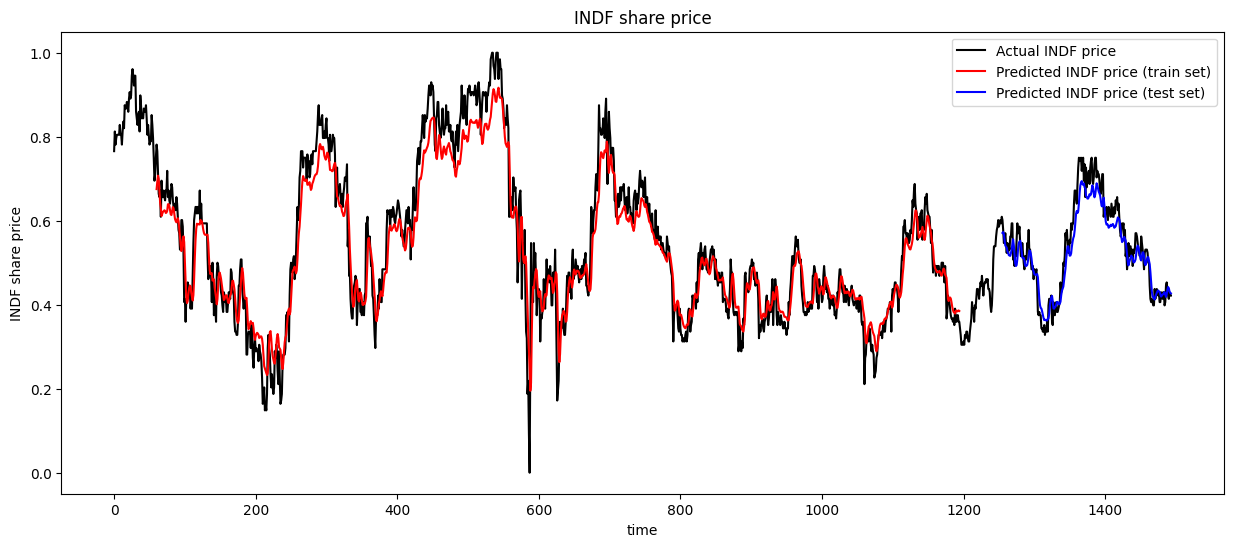

In [107]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [108]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 31ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6416.48486328125
Day 2: Predicted Price = 6419.95458984375
Day 3: Predicted Price = 6426.0078125
Day 4: Predicted Price = 6432.05126953125
Day 5: Predicted Price = 6437.23681640625
Day 6: Predicted Price = 6441.51220703125
Day 7: Predicted Price = 6445.060546875
Day 8: Predicted Price = 6448.0791015625
Day 9: Predicted Price = 6450.71875
Day 10: Predicted Price = 6453.07861328125
Day 11: Predicted Price = 6455.22021484375
Day 12: Predicted Price = 6457.17919921875
Day 13: Predicted Price = 6458.97607421875
Day 14: Predicted Price = 6460.62109375
Day 15: Predicted Price = 6462.12255859375
Day 16: Predicted Price = 6463.48876953125
Day 17: Predicted Price = 6464.72607421875
Day 18: Predicted Price = 6465.84326171875
Day 19: Predicted Price = 6466.8486328125
Day 20: Predicted Price = 6467.75146484375
Day 21: Predicted Price = 6468.55908203125
Day 22: Predicted Price = 6469.281738

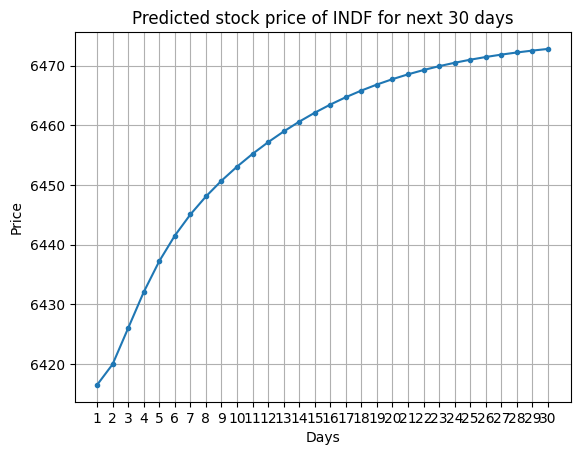

In [109]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [110]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 22ms/step - loss: 0.0014
Validation Loss: 0.0014205711195245385
Validation MSE Loss: 0.0014205711195245385


In [111]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.05722301487575254
Testing RMSE: 0.037690466878316634


dropout = 0.6

In [112]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.6))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=50))
model.add(Dropout(0.6))

model.add(Dense(units=1))

In [113]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_21 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_22 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [114]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [115]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 8s 92ms/step - loss: 0.0597 - val_loss: 0.0071
Epoch 2/100
36/36 [==============================] - 2s 60ms/step - loss: 0.0257 - val_loss: 0.0051
Epoch 3/100
36/36 [==============================] - 2s 57ms/step - loss: 0.0230 - val_loss: 0.0035
Epoch 4/100
36/36 [==============================] - 2s 57ms/step - loss: 0.0205 - val_loss: 0.0031
Epoch 5/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0206 - val_loss: 0.0032
Epoch 6/100
36/36 [==============================] - 2s 58ms/step - loss: 0.0183 - val_loss: 0.0032
Epoch 7/100
36/36 [==============================] - 3s 76ms/step - loss: 0.0163 - val_loss: 0.0036
Epoch 8/100
36/36 [==============================] - 3s 70ms/step - loss: 0.0158 - val_loss: 0.0054
Epoch 9/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0165 - val_loss: 0.0024
Epoch 10/100
36/36 [==============================] - 2s 66ms/step - loss: 0.0150 - val_loss: 0.0022

In [116]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 21ms/step


In [117]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [118]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.05083745486699888
0.031864410026458845


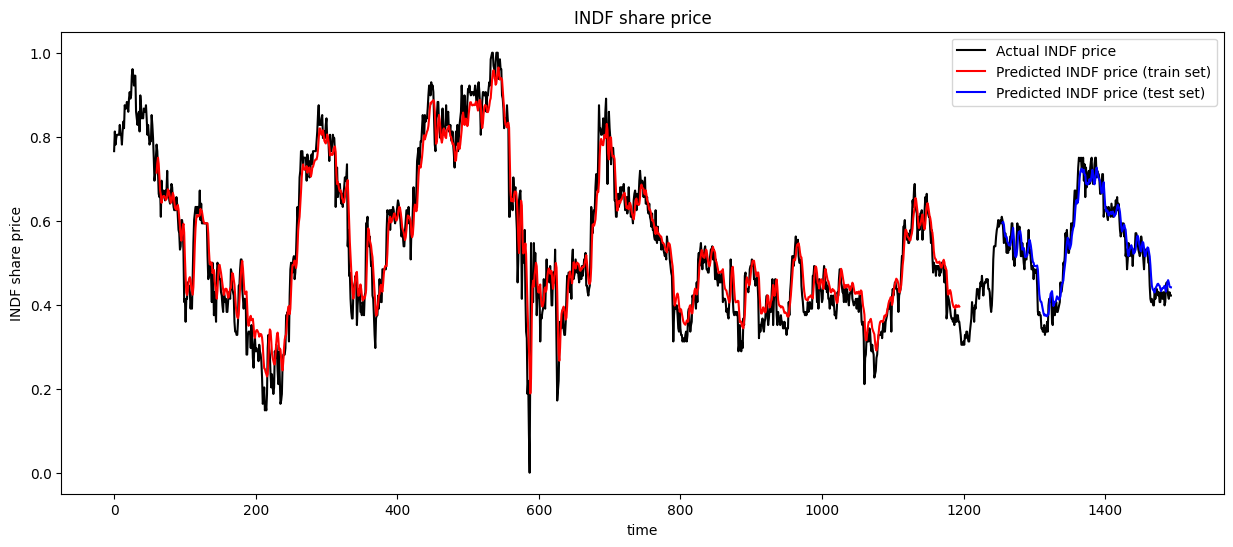

In [119]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [120]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 25ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6462.7333984375
Day 2: Predicted Price = 6482.1533203125
Day 3: Predicted Price = 6507.6904296875
Day 4: Predicted Price = 6532.3037109375
Day 5: Predicted Price = 6554.09619140625
Day 6: Predicted Price = 6573.078125
Day 7: Predicted Price = 6589.7734375
Day 8: Predicted Price = 6604.7548828125
Day 9: Predicted Price = 6618.49267578125
Day 10: Predicted Price = 6631.33154296875
Day 11: Predicted Price = 6643.49267578125
Day 12: Predicted Price = 6655.1064453125
Day 13: Predicted Price = 6666.23779296875
Day 14: Predicted Price = 6676.91259765625
Day 15: Predicted Price = 6687.1376953125
Day 16: Predicted Price = 6696.91162109375
Day 17: Predicted Price = 6706.23388671875
Day 18: Predicted Price = 6715.109375
Day 19: Predicted Price = 6723.5458984375
Day 20: Predicted Price = 6731.55810546875
Day 21: Predicted Price = 6739.1611328125
Day 22: Predicted Price = 6746.37451171875


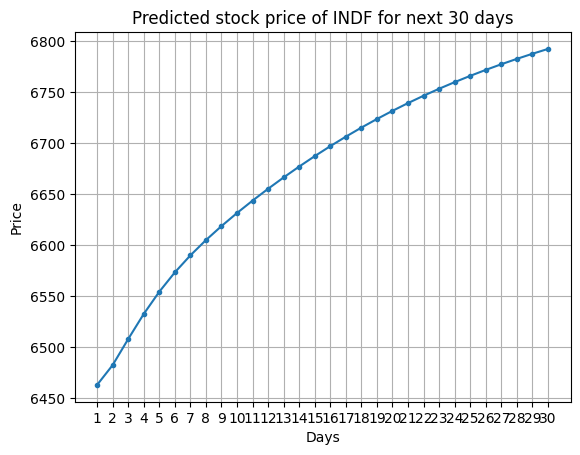

In [121]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [122]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 18ms/step - loss: 0.0010
Validation Loss: 0.0010153406765311956
Validation MSE Loss: 0.0010153406765311956


In [123]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.05083745486699888
Testing RMSE: 0.031864410026458845


: 